# Titanic: Machine Learning from disaster

#### Configuraciones iniciales

In [1]:
options(scipen = 999, repr.plot.width=4, repr.plot.height= 4, warn = -1)

#### Instalación y carga de paquetes necesarios

In [236]:
list.of.packages <- c('ggplot2', 'VIM', 'mice', 'mlbench', 'caret', 'caretEnsemble', 'gbm', 'ipred', 'FSelector',
                     'Matrix')

new.packages <- list.of.packages[!(list.of.packages %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(new.packages, repos = "https://cran.r-project.org")

library(ggplot2)
library(VIM)
library(mice)
library(mlbench)
library(caret)
library(caretEnsemble)
library(gbm)
library(ipred)
library(FSelector)
library(Matrix)

## Comprensión de datos

En una primera instancia debemos cargar y explorar los datos para entender el contexto en donde nos encontramos.

In [103]:
df_train <- read.csv("train.csv")
df_test <- read.csv("test.csv")

df_test$Survived <- NA
df_train <- rbind(df_train, df_test)

head(df_train)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [104]:
str(df_train)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...
 $ Embarked   : Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...


El dataset de entrenamiento contiene 891 pasajeros con 12 variables cada una.

### Verificación de datos faltantes.

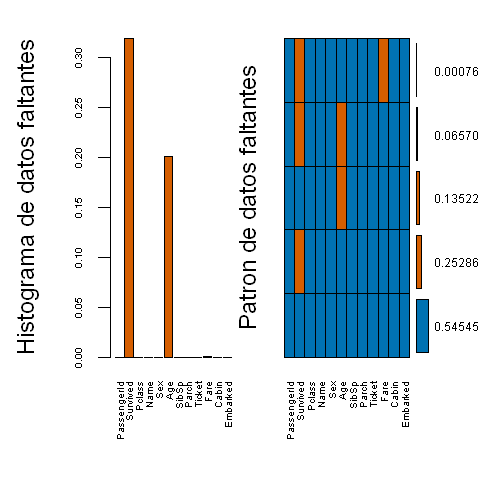

In [105]:
aggr(df_train, digits = 3, numbers = TRUE, labels = names(df_train), cex.axis = .5, cex.numbers = .6,
       gap = 2, ylabs = c("Histograma de datos faltantes", "Patron de datos faltantes"), col = c('#0072B2', '#D55E00'))

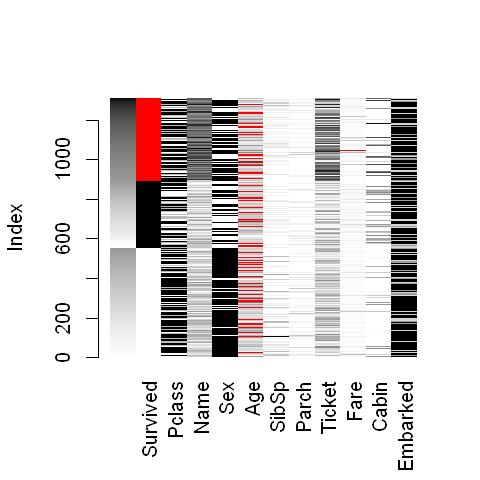

In [106]:
matrixplot(df_train, interactive = F, sortby = "Survived")

El atributo Age (Edad) falta en el 20% de los datos. Los demás se ven completos.

### Atributo: Survived
Indica si el pasajero sobrevivió o no (Sí = 1; No = 0).

In [107]:
table(df_train$Survived)
round(prop.table(table(df_train$Survived) * 100), 2)


  0   1 
549 342 


   0    1 
0.62 0.38 

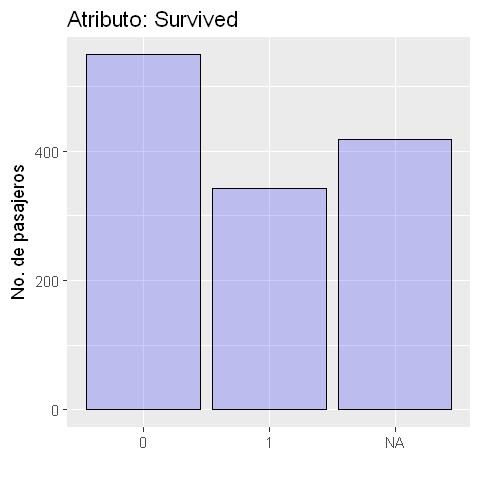

In [108]:
ggplot(data = df_train, aes(x = as.factor(Survived))) + geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Survived') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 62% de los pasajeros sobrevivieron mientras que el 38% no pudieron sobrevivir.

### Atributo: Pclass
Indica la clase social del pasajero: Primera, segunda o tercera clase. (1 = 1st; 2 = 2nd; 3 = 3rd)

In [109]:
table(df_train$Pclass)
round(prop.table(table(df_train$Pclass) * 100), 2)


  1   2   3 
323 277 709 


   1    2    3 
0.25 0.21 0.54 

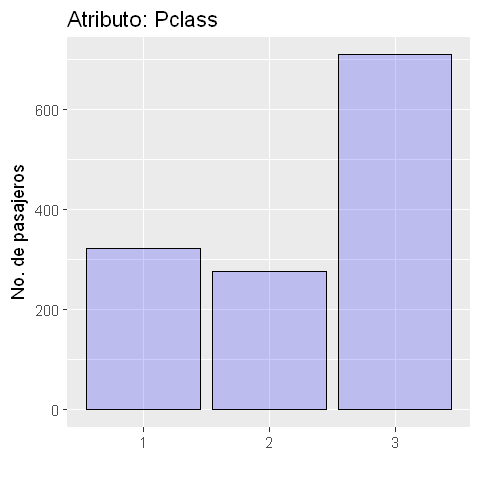

In [110]:
ggplot(data = df_train, aes(x = as.factor(Pclass))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Pclass') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 55% de los pasajeros correspondían a la tercera clase. Esto es el doble de las primera y segunda clase juntos.

### Atributo: Name
Nombre del pasajero.
Los nombres están compuestos de la siguiente forma: Apellido, **Title.** Nombre
Lo que haremos es extraer el Título como una columna aparte.

In [111]:
head(df_train$Name)

df_train$Title <- gsub(".*,\\s([a-zA-Z]+)..*", "\\1", df_train$Name)
df_train$Name <- gsub("(.*),\\s[a-zA-Z]+.\\s(.*)", "\\2 \\1", df_train$Name)

unique(df_train$Title)
length(unique(df_train$Title))

[1] Braund, Mr. Owen Harris                            
[2] Cumings, Mrs. John Bradley (Florence Briggs Thayer)
[3] Heikkinen, Miss. Laina                             
[4] Futrelle, Mrs. Jacques Heath (Lily May Peel)       
[5] Allen, Mr. William Henry                           
[6] Moran, Mr. James                                   
1307 Levels: Abbing, Mr. Anthony ... Zakarian, Mr. Ortin

[1] "Mr"       "Mrs"      "Miss"     "Master"   "Don"      "Rev"     
 [7] "Dr"       "Mme"      "Ms"       "Major"    "Lady"     "Sir"     
[13] "Mlle"     "Col"      "Capt"     "the"      "Jonkheer" "Dona"

[1] 18

Como podemos ver hay 17 títulos diferentes sin contar el título "the" que parece un error.

In [112]:
table(df_train$Title)


    Capt      Col      Don     Dona       Dr Jonkheer     Lady    Major 
       1        4        1        1        8        1        1        2 
  Master     Miss     Mlle      Mme       Mr      Mrs       Ms      Rev 
      61      260        2        1      757      197        2        8 
     Sir      the 
       1        1 

In [113]:
idx <- which(df_train$Title == "the")
df_train$Name[idx]

df_train$Title[idx] <- 'Countess'
df_train$Title <- as.factor(df_train$Title)

[1] "Countess. of (Lucy Noel Martha Dyer-Edwards) Rothes"

Reemplazamos el erróneo "the" con el valor correcto que es Countess.

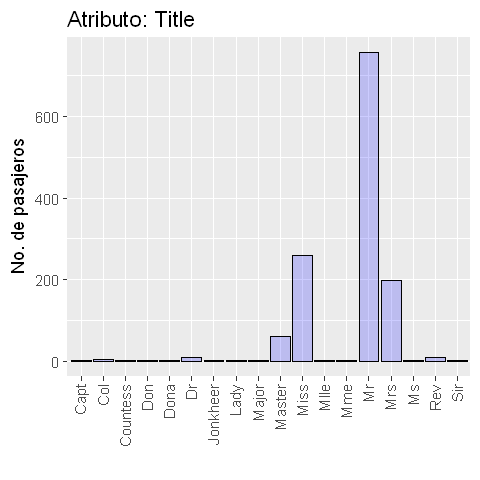

In [114]:
ggplot(data = df_train, aes(x = as.factor(Title))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Title') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

Los títulos más utilizados son Mr., Miss, Mrs. Probablemente por la abundancia de pasajeros en tercera clase.

### Atributo: Sex
Género del pasajero: Male (hombre) o Female (mujer) 

In [115]:
table(df_train$Sex)
round(prop.table(table(df_train$Sex))*100,2)

table(is.na(df_train$Sex))


female   male 
   466    843 


female   male 
  35.6   64.4 


FALSE 
 1309 

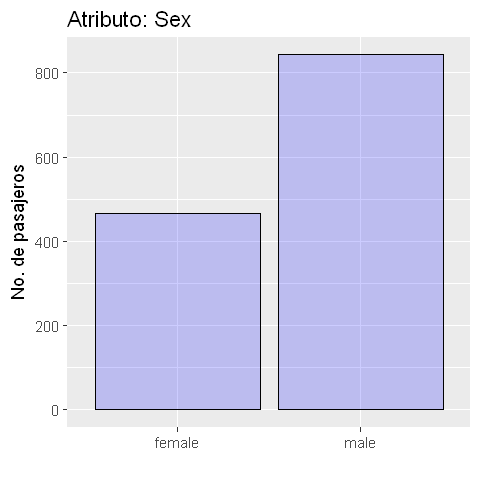

In [116]:
ggplot(data = df_train, aes(x = as.factor(Sex))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Sex') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 65% de los pasajeros corresponde a hombres.

### Atributo: Age
Edad del pasajero.

In [117]:
summary(df_train$Age)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   0.17   21.00   28.00   29.88   39.00   80.00     263 

La edad promedio de los pasajeros es de 30 años mientras que la mediana es de 28 años. La edad máxima es de 80 años.
No se tiene la edad de 177 pasajeros.

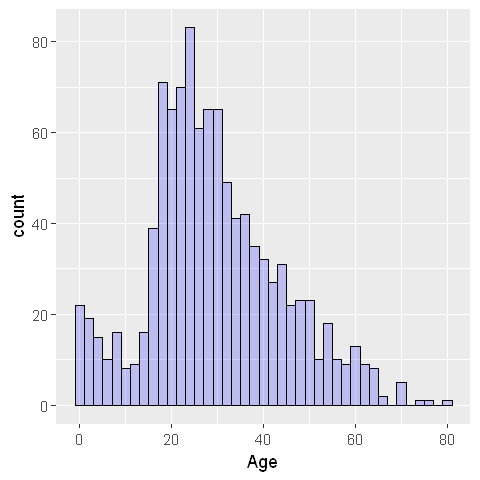

In [118]:
ggplot(data = df_train, aes(x = Age)) + geom_histogram(binwidth = 2, col="black", fill="blue", alpha = .2)

La mayor parte de los pasajeros tienen entre 20 y 40 años. Como vimos la mediana es de 28 años.

Para aquellos que no tienen las edades cargadas lo reemplazaremos con valores entre el primer y tercer cuartil.

In [119]:
na_count <- sum(is.na(df_train$Age))
set.seed(123)

ages <- round(runif(na_count, summary(df_train$Age)[2], summary(df_train$Age)[5]), 2)
head(ages)

[1] 26.18 35.19 28.36 36.89 37.93 21.82

In [120]:
df_train$Age[which(is.na(df_train$Age))] <- ages

Una vez que imputamos los datos volvemos a graficar.

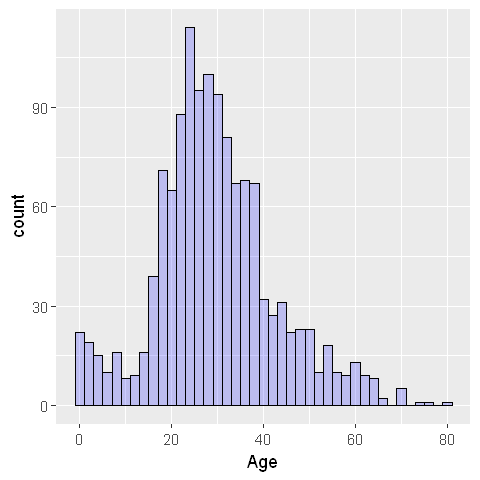

In [121]:
ggplot(data = df_train, aes(x = Age)) + geom_histogram(binwidth = 2, col="black", fill="blue", alpha = .2)

Ahora discreticemos el atributo Age de la siguiente forma:
1. Bebé: entre 0 y 3 años
2. Niño: entre 3 y 18 años
3. Adulto: entre 18 y 50 años
4. Anciano: mayor a 50 años

In [122]:
df_train$AgeD <- "Bebé"
df_train$AgeD[df_train$Age >= 3] <- "Niño"
df_train$AgeD[df_train$Age >= 18] <- "Adulto"
df_train$AgeD[df_train$Age >= 50] <- "Anciano"

ages <- c("Bebé", "Niño", "Adulto", "Anciano")

df_train$AgeD <- factor(df_train$AgeD, labels = ages, levels = ages)

table(df_train$AgeD)
round(prop.table(table(df_train$AgeD)) * 100,2)


   Bebé    Niño  Adulto Anciano 
     34     120    1045     110 


   Bebé    Niño  Adulto Anciano 
   2.60    9.17   79.83    8.40 

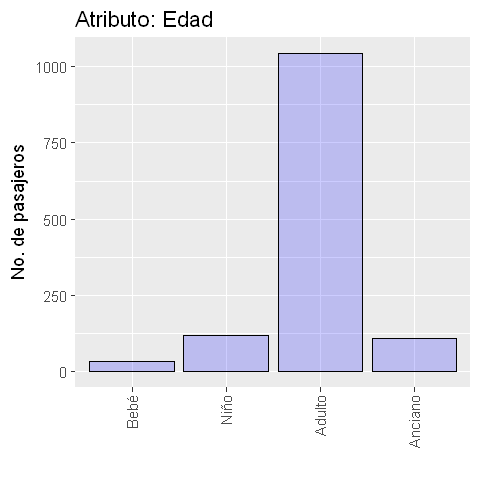

In [123]:
ggplot(data = df_train, aes(x = as.factor(AgeD))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Edad') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

Como vemos en el gráfico la mayoría de los tripulantes eran adultos, y casi el 23% eran bebés.

### Atributo: SibSp
Número de hermanos/esposas a bordo por pasajero.

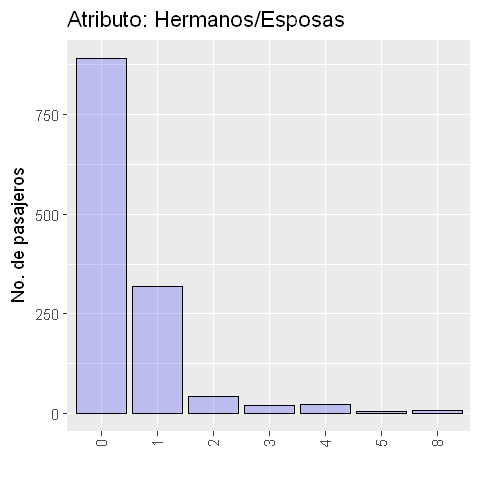

In [124]:
df_train$SibSp <- factor(df_train$SibSp, levels = sort(unique(df_train$SibSp)), labels = sort(unique(df_train$SibSp)))

ggplot(data = df_train, aes(x = as.factor(SibSp))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Hermanos/Esposas') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

In [125]:
table(df_train$SibSp)
round(prop.table(table(df_train$SibSp)) * 100, 2)


  0   1   2   3   4   5   8 
891 319  42  20  22   6   9 


    0     1     2     3     4     5     8 
68.07 24.37  3.21  1.53  1.68  0.46  0.69 

El 90% de los pasajeros no tenía un hermano/esposa o tenía al menos 1.

### Atributo: parch
Número de padres/hijos a bordo.

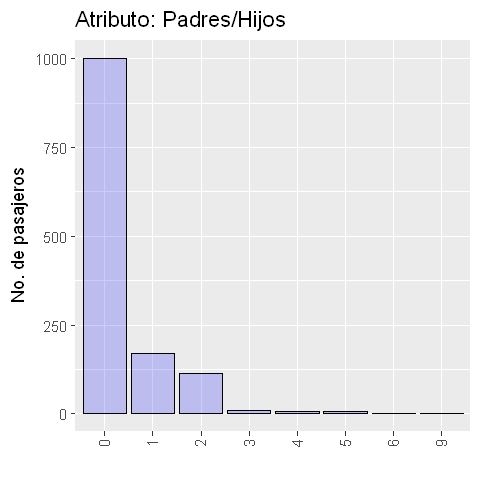

In [126]:
df_train$Parch<- factor(df_train$Parch, levels = sort(unique(df_train$Parch)), labels = sort(unique(df_train$Parch)))

ggplot(data = df_train, aes(x = as.factor(Parch))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Padres/Hijos') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

In [127]:
table(df_train$Parch)
round(prop.table(table(df_train$Parch)) * 100, 2)


   0    1    2    3    4    5    6    9 
1002  170  113    8    6    6    2    2 


    0     1     2     3     4     5     6     9 
76.55 12.99  8.63  0.61  0.46  0.46  0.15  0.15 

El 75% de los pasajeros no tenían padres o hijos a bordo.

### Atributo: Family Size = SibSp + Parch 
Podemos construir un nuevo atributo a partir de los otros dos. Esto contendrá el tamaño de la familia.

In [128]:
df_train$FamilySize <- as.integer(df_train$SibSp) + as.integer(df_train$Parch) + 1

table(df_train$FamilySize)
round(prop.table(table(df_train$FamilySize)) * 100, 2)


  3   4   5   6   7   8   9  10  11 
790 235 159  43  22  25  16   8  11 


    3     4     5     6     7     8     9    10    11 
60.35 17.95 12.15  3.28  1.68  1.91  1.22  0.61  0.84 

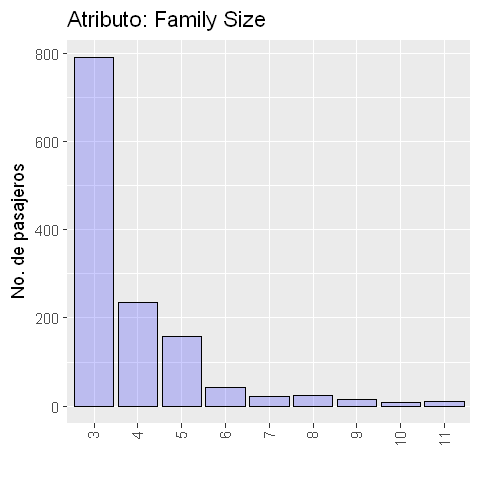

In [129]:
ggplot(data = df_train, aes(x = as.factor(FamilySize))) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Family Size') + 
    xlab('') + 
    ylab('No. de pasajeros') + 
    theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.4))

### Atributo: Ticket
Número del ticket.

In [130]:
df_train$Ticket <- as.integer(df_train$Ticket)

### Atributo: Fare
Es la tarifa que pagó el pasajero.

In [131]:
summary(df_train$Fare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   7.896  14.450  33.300  31.280 512.300       1 

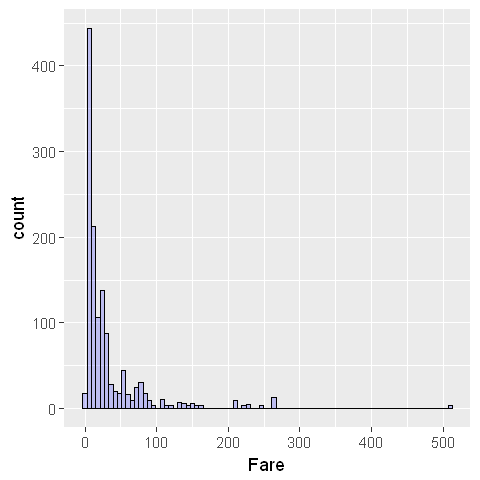

In [132]:
ggplot(data = df_train, aes(x = Fare)) + geom_histogram(binwidth = 6, col="black", fill="blue", alpha = .2)

El promedio del precio de un ticket es de \$33, mientras que lo máximo que se pagó por uno fue más de \$500. Podemos ver que hay tickets con valor \$0. Veamos estas observaciones si hay algún error.

In [133]:
df_train[df_train$Fare == 0,]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,AgeD,FamilySize
180,180,0,3,Lionel Leonard,male,36.00,0,0,575,0,,S,Mr,Adulto,3
264,264,0,1,William Harrison,male,40.00,0,0,17,0,B94,S,Mr,Adulto,3
272,272,1,3,William Henry Tornquist,male,25.00,0,0,575,0,,S,Mr,Adulto,3
278,278,0,2,"Francis ""Frank"" Parkes",male,31.10,0,0,136,0,,S,Mr,Adulto,3
303,303,0,3,William Cahoone Jr Johnson,male,19.00,0,0,575,0,,S,Mr,Adulto,3
414,414,0,2,Alfred Fleming Cunningham,male,33.03,0,0,136,0,,S,Mr,Adulto,3
467,467,0,2,William Campbell,male,32.82,0,0,136,0,,S,Mr,Adulto,3
482,482,0,2,"Anthony Wood ""Archie"" Frost",male,22.68,0,0,137,0,,S,Mr,Adulto,3
598,598,0,3,Alfred Johnson,male,49.00,0,0,575,0,,S,Mr,Adulto,3
634,634,0,1,William Henry Marsh Parr,male,33.11,0,0,14,0,,S,Mr,Adulto,3


Reemplazemos estos valores con la mediana.

In [134]:
df_train$Fare[which(df_train$Fare == 0)] <- median(df_train$Fare, na.rm = TRUE)

Ahora vemos que el mínimo es \$4 y volvemos a graficar el histograma.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  3.171   7.925  14.450  33.480  31.280 512.300       1 

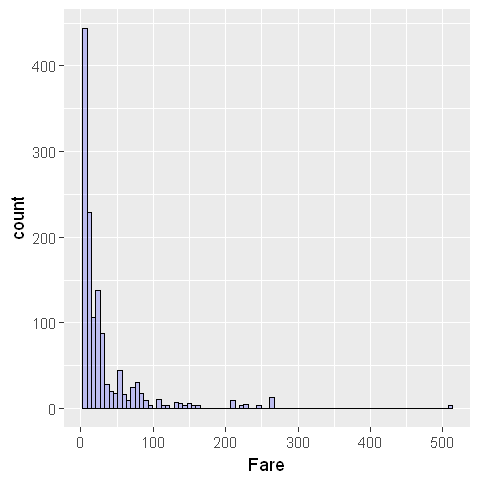

In [135]:
summary(df_train$Fare)
ggplot(data = df_train, aes(x = Fare)) + geom_histogram(binwidth = 6, col="black", fill="blue", alpha = .2)

### Atributo: Cabin
Cabina.

In [136]:
str(df_train$Cabin)
head(df_train$Cabin)

df_train$Cabin[df_train$Cabin == ""] <- NA

table(is.na(df_train$Cabin))
round(prop.table(table(is.na(df_train$Cabin)))*100,2)

 Factor w/ 187 levels "","A10","A14",..: 1 83 1 57 1 1 131 1 1 1 ...


[1]      C85       C123          
187 Levels:  A10 A14 A16 A19 A20 A23 A24 A26 A31 A32 A34 A36 A5 A6 A7 ... F E57


FALSE  TRUE 
  295  1014 


FALSE  TRUE 
22.54 77.46 

Ahora podemos ver que hay valores faltantes en el atributo Cabina, pero estaba codificados como caracteres en blanco. Falta el 23% de los datos en este atributo.

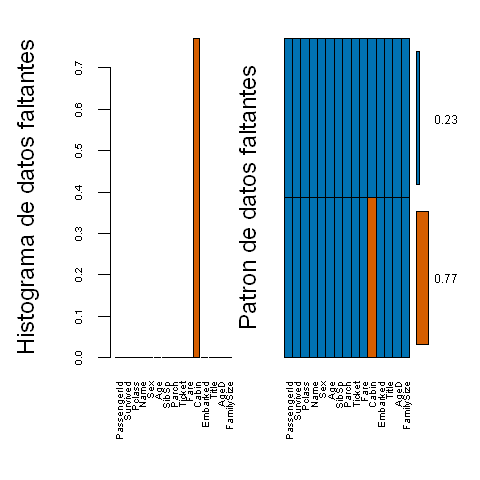

In [37]:
aggr(df_train, digits = 3, numbers = TRUE, labels = names(df_train), cex.axis = .5, cex.numbers = .6,
       gap = 2, ylabs = c("Histograma de datos faltantes", "Patron de datos faltantes"), col = c('#0072B2', '#D55E00'))

### Atributo: Embarked
Embarque. (C = Cherbourg; Q = Queenstown; S = Southampton)

In [38]:
str(df_train$Embarked)

df_train$Embarked[df_train$Embarked == ""] <- NA

table(df_train$Embarked)
round(prop.table(table(df_train$Embarked)) *100, 2)

table(is.na(df_train$Embarked))

 Factor w/ 4 levels "","C","Q","S": 4 2 4 4 4 3 4 4 4 2 ...



      C   Q   S 
  0 168  77 644 


          C     Q     S 
 0.00 18.90  8.66 72.44 


FALSE  TRUE 
  889     2 

Hay dos pasajeros que no tienen una Embarque asignado. Así que les asignaremos el valor más común que es S.

In [39]:
idx <- which(is.na(df_train$Embarked))
df_train$Embarked[idx] <- "S"
df_train$Embarked <- factor(df_train$Embarked)

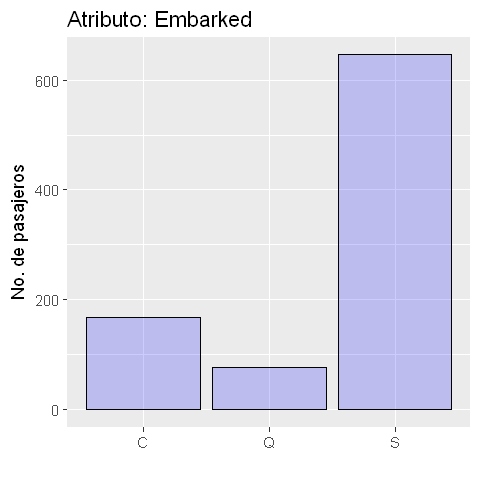

In [40]:
ggplot(data = df_train, aes(x = Embarked)) + 
    geom_bar(col="black", fill="blue", alpha = .2) + 
    ggtitle('Atributo: Embarked') + 
    xlab('') + 
    ylab('No. de pasajeros')

El 73% de los pasajeros partieron del mismo puerto.

*** 

### Análisis multivariado

Ahora veremos como se relacionan las variables entre sí para encontrar correlaciones.

In [41]:
str(df_train)

'data.frame':	891 obs. of  15 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Owen Harris Braund" "John Bradley (Florence Briggs Thayer) Cumings" "Laina Heikkinen" "Jacques Heath (Lily May Peel) Futrelle" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 ...
 $ SibSp      : Factor w/ 7 levels "0","1","2","3",..: 2 2 1 2 1 1 1 4 1 2 ...
 $ Parch      : Factor w/ 7 levels "0","1","2","3",..: 1 1 1 1 1 1 1 2 3 1 ...
 $ Ticket     : int  524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 148 levels "","A10","A14",..: NA 83 NA 57 NA NA 131 NA NA NA ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title      : Factor w/ 17 levels "Capt","Col","Countess",..: 13 14 10 14 13 13 13 9 14 14 ...
 $ AgeD       : Factor

In [587]:
df_train$PassengerId <- NULL
df_train$Survived <- as.factor(df_train$Survived)
df_train$Pclass <- as.factor(df_train$Pclass)
df_train$Age <- NULL
df_train$Ticket <- NULL
df_train$Cabin <- NULL
df_train$FamilySize <- as.factor(df_train$FamilySize)

### Atributos: Survived vs. Pclass

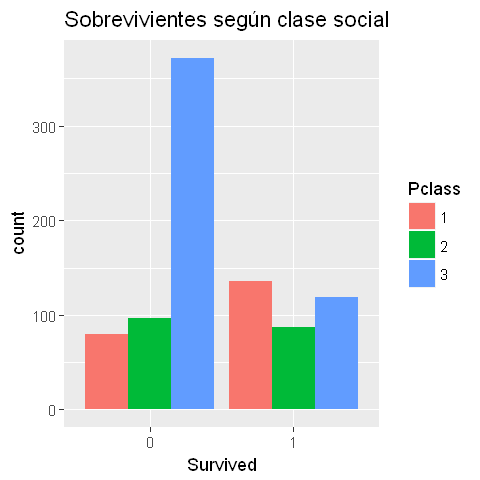

In [588]:
ggplot(df_train, aes(Survived, ..count..)) + geom_bar(aes(fill = Pclass), position = "dodge") +
    ggtitle("Sobrevivientes según clase social")

La cantidad de pasajeros que sobrevivieron y que no en la primera clase es casi la misma, igualmente para la segunda clase. No así para la tercera clase donde no sobrevivieron casi 400 personas.

### Atributos: Survived vs. Sex

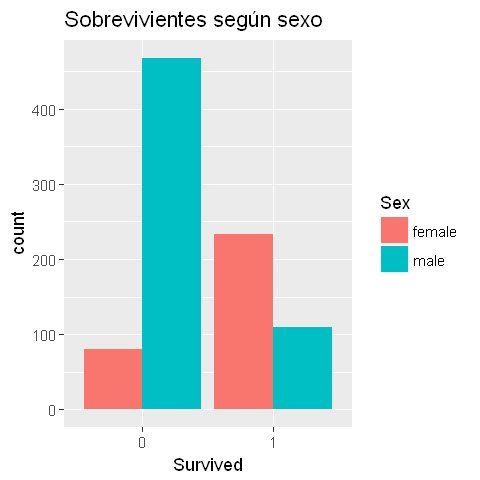

In [589]:
ggplot(df_train, aes(Survived, ..count..)) + geom_bar(aes(fill = Sex), position = "dodge") +
    ggtitle("Sobrevivientes según sexo")

La proporción de hombres que no sobrevivieron es mucho mayor que las mujeres que no sobrevivieron, esto es debido a la prioridad que tenían las mujeres para subirse a los botes.

### Atributos: Survived vs. Age

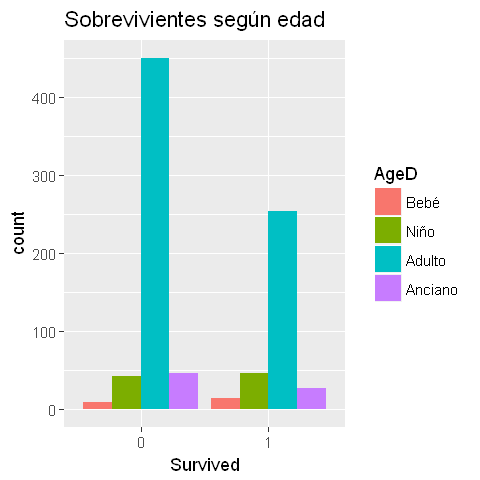

In [590]:
ggplot(df_train, aes(Survived, ..count..)) + geom_bar(aes(fill = AgeD), position = "dodge") +
    ggtitle("Sobrevivientes según edad")

Sobrevivieron más niños que ancianos o bebés.
Los adultos tenían mucha probabilidad de no sobrevivir dado a que las prioridades eran los niños.

### Atributos: Survived vs FamilySize

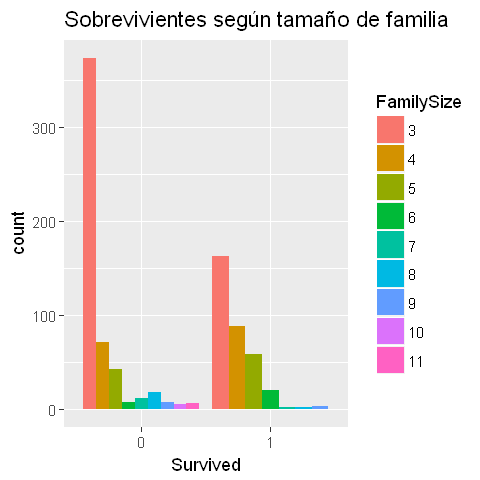

In [591]:
ggplot(df_train, aes(Survived, ..count..)) + geom_bar(aes(fill = FamilySize), position = "dodge") +
    ggtitle("Sobrevivientes según tamaño de familia")

Las familias más chicas a bordo tenían menos chances de sobrevivir. Las familias a bordo que eran más grandes tenían más chances de supervivencia.

### Atributos: Survived vs. Fare

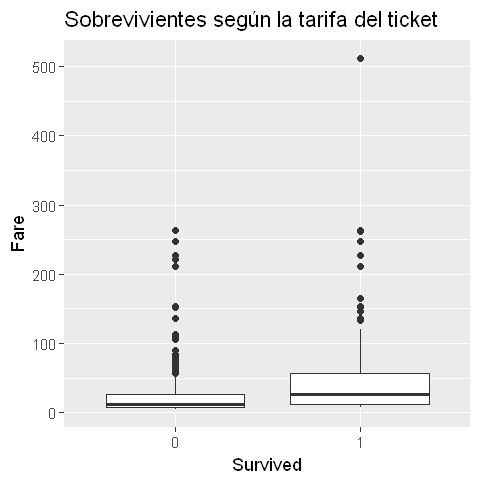

In [592]:
ggplot(df_train, aes(Survived, Fare)) + geom_boxplot() +
    ggtitle("Sobrevivientes según la tarifa del ticket")

Los que poseían tarifas de mayor valor tenían más chances de sobrevivir, quizás porque pertenecían a clase más alta.

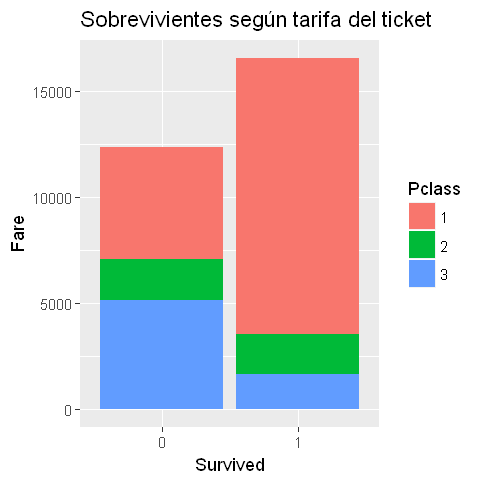

In [593]:
ggplot(df_train, aes(Survived, Fare, fill = Pclass)) + geom_bar(stat='identity') +
    ggtitle("Sobrevivientes según tarifa del ticket")

Podemos corroborar con el gráfico anterior que los de primera clase tenían tarifas más caras. 
Recordemos que la tercera clase representa el 50% de los pasajeros e incluso así son minoría en el gráfico. (El tamaño de cada bloque está dado por la suma de todos los tickets para esa clase).

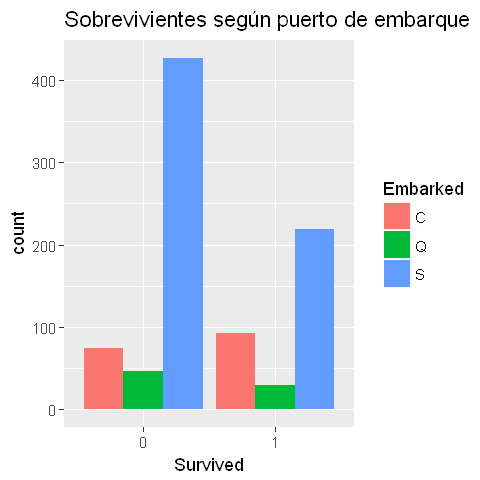

In [594]:
ggplot(df_train, aes(Survived, ..count..)) + geom_bar(aes(fill = Embarked), position = "dodge") +
    ggtitle("Sobrevivientes según puerto de embarque")

Los que embarcaron en Southampton tenían menos chances de sobrevivir. Veamos si tiene que ver la clase social.

## Preparación de datos

In [155]:
df_train <- read.csv("train.csv", na.strings = c("", "NA"))
df_test <- read.csv("test.csv", na.strings = c("", "NA"))

df_test$Survived <- NA
df_train <- rbind(df_train, df_test)

str(df_train)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : Factor w/ 1307 levels "Abbing, Mr. Anthony",..: 109 191 358 277 16 559 520 629 417 581 ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : Factor w/ 929 levels "110152","110413",..: 524 597 670 50 473 276 86 396 345 133 ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : Factor w/ 186 levels "A10","A14","A16",..: NA 82 NA 56 NA NA 130 NA NA NA ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


In [156]:
df_train$Survived <- make.names(df_train$Survived)
df_train$Survived[df_train$Survived == "NA."] <- NA
df_train$Survived <- as.factor(df_train$Survived)

df_train$Pclass <- make.names(df_train$Pclass)
df_train$Pclass[df_train$Pclass == "NA."] <- NA
df_train$Pclass <- as.factor(df_train$Pclass)

df_train$Title <- gsub(".*,\\s([a-zA-Z]+)..*", "\\1", df_train$Name)
idx <- which(df_train$Title == "the")
df_train$Title[idx] <- 'Countess'
df_train$Title <- make.names(df_train$Title)
df_train$Title[df_train$Title == "NA."] <- NA
df_train$Title <- as.factor(df_train$Title)

df_train$Sex <- make.names(df_train$Sex)
df_train$Sex[df_train$Sex == "NA."] <- NA
df_train$Sex <- as.factor(df_train$Sex)

df_train$AgeD <- "Bebé"
df_train$AgeD[df_train$Age >= 3] <- "Niño"
df_train$AgeD[df_train$Age >= 18] <- "Adulto"
df_train$AgeD[df_train$Age >= 50] <- "Anciano"
ages <- c("Bebé", "Niño", "Adulto", "Anciano")
df_train$AgeD <- make.names(df_train$AgeD)
df_train$AgeD[df_train$AgeD == "NA."] <- NA
df_train$AgeD <- factor(df_train$AgeD, labels = ages, levels = ages)

df_train$FamSize <- df_train$SibSp + df_train$Parch + 1
df_train$FamSize <- make.names(df_train$FamSize)
df_train$FamSize[df_train$FamSize == "NA."] <- NA
df_train$FamSize <- as.factor(df_train$FamSize)

df_train$SibSp <- make.names(df_train$SibSp)
df_train$SibSp[df_train$SibSp == "NA."] <- NA
df_train$SibSp <- as.factor(df_train$SibSp)

df_train$Parch <- make.names(df_train$Parch)
df_train$Parch[df_train$Parch == "NA."] <- NA
df_train$Parch <- as.factor(df_train$Parch)

df_train$Fare[which(df_train$Fare == 0)] <- NA

df_train$Deck <- substring(df_train$Cabin, 1, 1)
df_train$Deck <- make.names(df_train$Deck)
df_train$Deck[df_train$Deck == "NA."] <- NA
df_train$Deck <- as.factor(df_train$Deck)

df_train$Embarked <- as.character(df_train$Embarked)
df_train$Embarked <- make.names(df_train$Embarked)
df_train$Embarked[df_train$Embarked == "NA."] <- NA
df_train$Embarked <- as.factor(df_train$Embarked)


df_train[, c('PassengerId', 'Ticket', 'Name', 'Age', 'Cabin')] <- NULL


str(df_train)

'data.frame':	1309 obs. of  11 variables:
 $ Survived: Factor w/ 2 levels "X0","X1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass  : Factor w/ 3 levels "X1","X2","X3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ SibSp   : Factor w/ 7 levels "X0","X1","X2",..: 2 2 1 2 1 1 1 4 1 2 ...
 $ Parch   : Factor w/ 8 levels "X0","X1","X2",..: 1 1 1 1 1 1 1 2 3 1 ...
 $ Fare    : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked: Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...
 $ Title   : Factor w/ 18 levels "Capt","Col","Countess",..: 14 15 11 15 14 14 14 10 15 15 ...
 $ AgeD    : Factor w/ 4 levels "Bebé","Niño",..: 3 3 3 3 3 1 4 1 3 2 ...
 $ FamSize : Factor w/ 9 levels "X1","X11","X2",..: 3 3 1 3 1 1 1 6 4 3 ...
 $ Deck    : Factor w/ 8 levels "A","B","C","D",..: NA 3 NA 3 NA NA 5 NA NA NA ...


,Pclass,Sex,SibSp,Parch,Title,AgeD,FamSize,Embarked,Fare,Survived,Deck,
199,1,1,1,1,1,1,1,1,1,1,1,0
90,1,1,1,1,1,1,1,1,1,0,1,1
3,1,1,1,1,1,1,1,1,0,1,1,1
2,1,1,1,1,1,1,1,0,1,1,1,1
675,1,1,1,1,1,1,1,1,1,1,0,1
1,1,1,1,1,1,1,1,1,0,0,1,2
325,1,1,1,1,1,1,1,1,1,0,0,2
12,1,1,1,1,1,1,1,1,0,1,0,2
2,1,1,1,1,1,1,1,1,0,0,0,3
,0,0,0,0,0,0,0,2,18,418,1014,1452


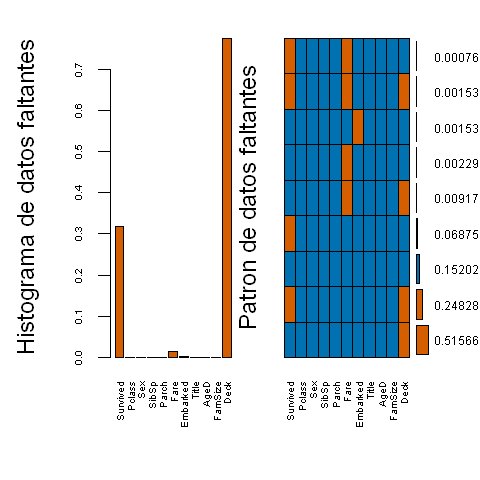

In [157]:
md.pattern(df_train)
aggr(df_train, digits = 3, numbers = TRUE, labels = names(df_train), cex.axis = .5, cex.numbers = .6,
       gap = 2, ylabs = c("Histograma de datos faltantes", "Patron de datos faltantes"), col = c('#0072B2', '#D55E00'))

In [158]:
tempData <- mice(df_train, m=1, maxit=50, meth='pmm', seed=500)


 iter imp variable
  1   1  Survived  Fare  Embarked  Deck
  2   1  Survived  Fare  Embarked  Deck
  3   1  Survived  Fare  Embarked  Deck
  4   1  Survived  Fare  Embarked  Deck
  5   1  Survived  Fare  Embarked  Deck
  6   1  Survived  Fare  Embarked  Deck
  7   1  Survived  Fare  Embarked  Deck
  8   1  Survived  Fare  Embarked  Deck
  9   1  Survived  Fare  Embarked  Deck
  10   1  Survived  Fare  Embarked  Deck
  11   1  Survived  Fare  Embarked  Deck
  12   1  Survived  Fare  Embarked  Deck
  13   1  Survived  Fare  Embarked  Deck
  14   1  Survived  Fare  Embarked  Deck
  15   1  Survived  Fare  Embarked  Deck
  16   1  Survived  Fare  Embarked  Deck
  17   1  Survived  Fare  Embarked  Deck
  18   1  Survived  Fare  Embarked  Deck
  19   1  Survived  Fare  Embarked  Deck
  20   1  Survived  Fare  Embarked  Deck
  21   1  Survived  Fare  Embarked  Deck
  22   1  Survived  Fare  Embarked  Deck
  23   1  Survived  Fare  Embarked  Deck
  24   1  Survived  Fare  Embarked  Deck
  25 

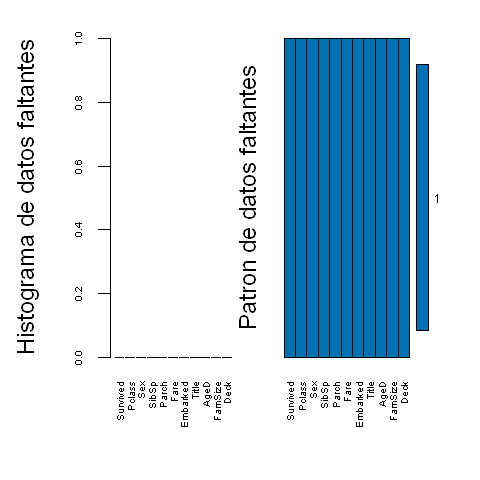

In [159]:
completedData <- complete(tempData,1)
aggr(completedData, digits = 3, numbers = TRUE, labels = names(df_train), cex.axis = .5, cex.numbers = .6,
       gap = 2, ylabs = c("Histograma de datos faltantes", "Patron de datos faltantes"), col = c('#0072B2', '#D55E00'))

## Modelado

In [160]:
dataset <- completedData

### Boosting algorithms


Call:
summary.resamples(object = boosting_results)

Models: c5.0, gbm 
Number of resamples: 30 

Accuracy 
       Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
c5.0 0.7923  0.8321 0.8506 0.8479  0.8623 0.9242    0
gbm  0.7939  0.8171 0.8321 0.8418  0.8626 0.9008    0

Kappa 
       Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
c5.0 0.5583  0.6395 0.6826 0.6794   0.708 0.8415    0
gbm  0.5663  0.6218 0.6505 0.6681   0.708 0.7969    0


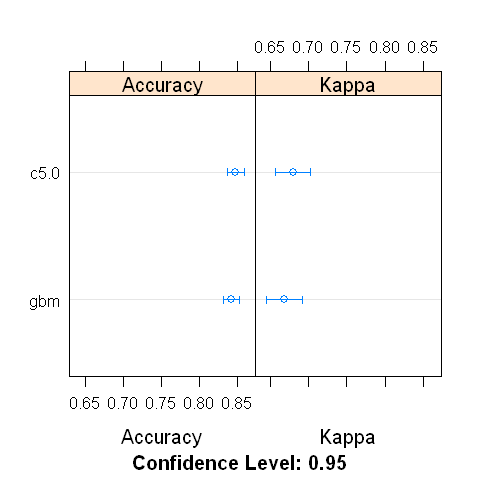

In [161]:
# Example of Boosting Algorithms
control <- trainControl(method="repeatedcv", number=10, repeats=3)
seed <- 7
metric <- "Accuracy"
# C5.0
set.seed(seed)
fit.c50 <- train(Survived~., data=dataset, method="C5.0", metric=metric, trControl=control)
# Stochastic Gradient Boosting
set.seed(seed)
fit.gbm <- train(Survived~., data=dataset, method="gbm", metric=metric, trControl=control, verbose=FALSE)
# summarize results
boosting_results <- resamples(list(c5.0=fit.c50, gbm=fit.gbm))
summary(boosting_results)
dotplot(boosting_results)

##### Resultados algoritmos con boosting:
c5.0: 84,79% <br>
gbm: 84,18%

### Bagging algorithms


Call:
summary.resamples(object = bagging_results)

Models: treebag, rf 
Number of resamples: 30 

Accuracy 
          Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
treebag 0.7405  0.8015 0.8314 0.8246  0.8473 0.8779    0
rf      0.7634  0.8234 0.8397 0.8352  0.8531 0.8855    0

Kappa 
          Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
treebag 0.4580  0.5831 0.6505 0.6352  0.6789 0.7493    0
rf      0.5103  0.6289 0.6625 0.6558  0.6901 0.7631    0


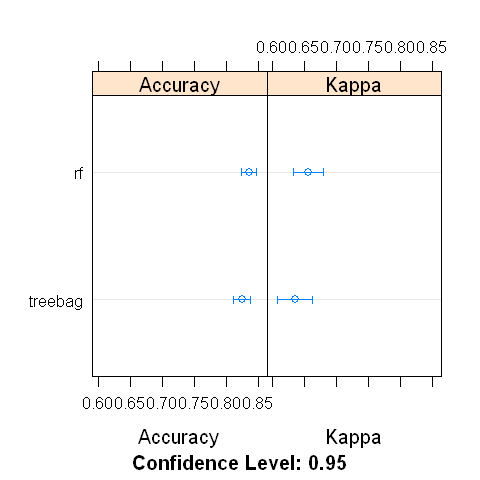

In [162]:
# Example of Bagging algorithms
control <- trainControl(method="repeatedcv", number=10, repeats=3)
seed <- 7
metric <- "Accuracy"
# Bagged CART
set.seed(seed)
fit.treebag <- train(Survived~., data=dataset, method="treebag", metric=metric, trControl=control)
# Random Forest
set.seed(seed)
fit.rf <- train(Survived~., data=dataset, method="rf", metric=metric, trControl=control)
# summarize results
bagging_results <- resamples(list(treebag=fit.treebag, rf=fit.rf))
summary(bagging_results)
dotplot(bagging_results)

##### Resultados algoritmos con bagging
Treebag: 82,46%<br>
Random Forest: 83,52% 

### Stacking algorithms

Creamos 5 submodelos:
1. Linear Discriminate Analysis (LDA)
2. Classification and Regression Trees (CART)
3. Logistic Regression (via Generalized Linear Model or GLM)
4. k-Nearest Neighbors (kNN)
5. Support Vector Machine with a Radial Basis Kernel Function (SVM)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3029             nan     0.1000    0.0260
     2        1.2584             nan     0.1000    0.0217
     3        1.2239             nan     0.1000    0.0176
     4        1.1949             nan     0.1000    0.0143
     5        1.1704             nan     0.1000    0.0116
     6        1.1520             nan     0.1000    0.0100
     7        1.1336             nan     0.1000    0.0082
     8        1.1211             nan     0.1000    0.0069
     9        1.1090             nan     0.1000    0.0055
    10        1.0997             nan     0.1000    0.0044
    20        1.0362             nan     0.1000    0.0016
    40        0.9816             nan     0.1000   -0.0000
    60        0.9506             nan     0.1000   -0.0003
    80        0.9317             nan     0.1000   -0.0001
   100        0.9150             nan     0.1000   -0.0003
   120        0.9028             nan     0.1000   -0.0013
   140        


Call:
summary.resamples(object = results)

Models: gbm, rpart, glm, knn, svmRadial 
Number of resamples: 30 

Accuracy 
            Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
gbm       0.7939  0.8171 0.8321 0.8418  0.8626 0.9008    0
rpart     0.7538  0.7939 0.8168 0.8197  0.8454 0.9015    0
glm       0.7405  0.7786 0.8077 0.8018  0.8219 0.8636    0
knn       0.7000  0.7576 0.7863 0.7833  0.8092 0.8485    0
svmRadial 0.7077  0.7793 0.8206 0.8064  0.8394 0.8788    0

Kappa 
            Min. 1st Qu. Median   Mean 3rd Qu.   Max. NA's
gbm       0.5663  0.6218 0.6505 0.6681  0.7080 0.7969    0
rpart     0.4812  0.5675 0.6157 0.6256  0.6750 0.7922    0
glm       0.4523  0.5396 0.5959 0.5840  0.6294 0.7114    0
knn       0.3619  0.4960 0.5510 0.5480  0.6062 0.6884    0
svmRadial 0.3839  0.5437 0.6272 0.5969  0.6616 0.7479    0


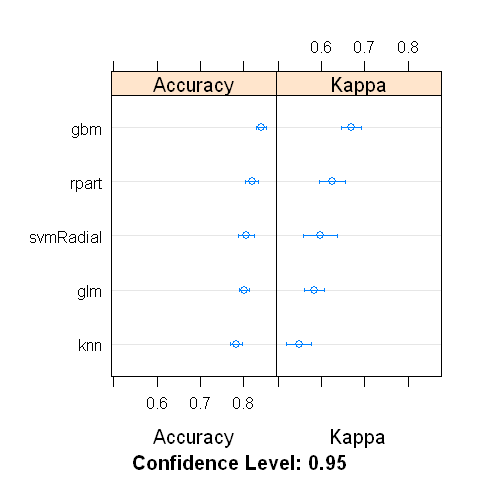

In [167]:
# Example of Stacking algorithms
# create submodels
control <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions=TRUE, classProbs=TRUE)
algorithmList <- c('gbm', 'rpart', 'glm', 'knn', 'svmRadial')
set.seed(seed)
models <- caretList(Survived~.-Survived, data=dataset, trControl=control, methodList=algorithmList)
results <- resamples(models)
summary(results)
dotplot(results)

,gbm,rpart,glm,knn,svmRadial
gbm,1.0000000,0.7656270,0.6314683,0.5393940,0.6411182
rpart,0.7656270,1.0000000,0.6701229,0.6821604,0.6914525
glm,0.6314683,0.6701229,1.0000000,0.5539906,0.6744476
knn,0.5393940,0.6821604,0.5539906,1.0000000,0.6727837
svmRadial,0.6411182,0.6914525,0.6744476,0.6727837,1.0000000


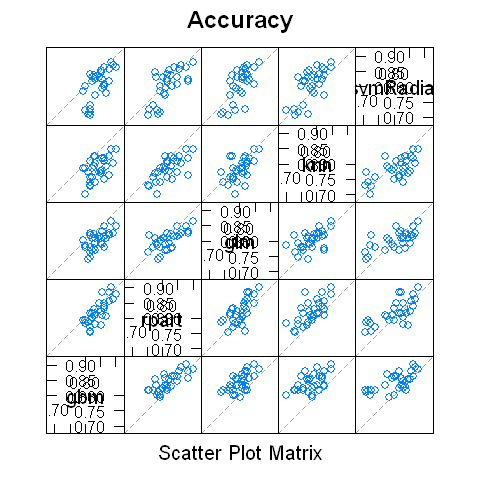

In [168]:
# correlation between results
modelCor(results)
splom(results)

In [169]:
# stack using glm
stackControl <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions=TRUE, classProbs=TRUE)
set.seed(seed)
stack.glm <- caretStack(models, method="glm", metric="Accuracy", trControl=stackControl)
print(stack.glm)

A glm ensemble of 2 base models: gbm, rpart, glm, knn, svmRadial

Ensemble results:
Generalized Linear Model 

3927 samples
   5 predictor
   2 classes: 'X0', 'X1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 3534, 3534, 3535, 3534, 3535, 3535, ... 
Resampling results:

  Accuracy   Kappa    
  0.8448291  0.6753849

 


In [170]:
# stack using gbm
stackControl <- trainControl(method="repeatedcv", number=10, repeats=3, savePredictions=TRUE, classProbs=TRUE)
set.seed(seed)
stack.gbm <- caretStack(models, method="gbm", metric="Accuracy", trControl=stackControl)
print(stack.gbm)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.2666             nan     0.1000    0.0420
     2        1.2002             nan     0.1000    0.0345
     3        1.1418             nan     0.1000    0.0283
     4        1.0940             nan     0.1000    0.0245
     5        1.0515             nan     0.1000    0.0199
     6        1.0167             nan     0.1000    0.0176
     7        0.9859             nan     0.1000    0.0147
     8        0.9594             nan     0.1000    0.0127
     9        0.9389             nan     0.1000    0.0105
    10        0.9198             nan     0.1000    0.0095
    20        0.8186             nan     0.1000    0.0025
    40        0.7668             nan     0.1000    0.0001
    60        0.7545             nan     0.1000    0.0000
    80        0.7470             nan     0.1000   -0.0001
   100        0.7419             nan     0.1000   -0.0003
   120        0.7373             nan     0.1000   -0.0002
   140        

In [171]:
# stack using random forest
set.seed(seed)
stack.rf <- caretStack(models, method="rf", metric="Accuracy", trControl=stackControl)
print(stack.rf)

A rf ensemble of 2 base models: gbm, rpart, glm, knn, svmRadial

Ensemble results:
Random Forest 

3927 samples
   5 predictor
   2 classes: 'X0', 'X1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 3 times) 
Summary of sample sizes: 3534, 3534, 3535, 3534, 3535, 3535, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.8544234  0.6961648
  3     0.8521312  0.6916363
  5     0.8524728  0.6923262

Accuracy was used to select the optimal model using  the largest value.
The final value used for the model was mtry = 2. 


Stack submodels using glm: 84,81% (n.trees=150, int.depth=3)
Stack submodels using random forest: 85,45%

In [213]:
#Test set
n <- nrow(read.csv("train.csv", na.strings = c("", "NA")))
df_test <- read.csv("test.csv", na.strings = c("", "NA"))

id_passengers <- df_test[,1] 

df_test <- dataset[id_passengers,]
str(df_test)

'data.frame':	418 obs. of  11 variables:
 $ Survived: Factor w/ 2 levels "X0","X1": 1 2 1 1 1 1 2 2 2 1 ...
  ..- attr(*, "contrasts")= num [1:2, 1] 0 1
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr  "X0" "X1"
  .. .. ..$ : chr "2"
 $ Pclass  : Factor w/ 3 levels "X1","X2","X3": 3 3 2 3 3 3 3 2 3 3 ...
  ..- attr(*, "contrasts")= num [1:3, 1:2] 0 1 0 0 0 1
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr  "X1" "X2" "X3"
  .. .. ..$ : chr  "2" "3"
 $ Sex     : Factor w/ 2 levels "female","male": 2 1 2 2 1 2 1 2 1 2 ...
  ..- attr(*, "contrasts")= num [1:2, 1] 0 1
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr  "female" "male"
  .. .. ..$ : chr "2"
 $ SibSp   : Factor w/ 7 levels "X0","X1","X2",..: 1 2 1 1 2 1 1 2 1 3 ...
  ..- attr(*, "contrasts")= num [1:7, 1:6] 0 1 0 0 0 0 0 0 0 1 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr  "X0" "X1" "X2" "X3" ...
  .. .. ..$ : chr  "2" "3" "4" "5" ...
 $ Parch   : Factor w/ 8 levels "X0","X1","X2",..: 1 

In [232]:
df_test$Survived <- NULL

fit2.gbm <- train(Survived ~ Pclass + Sex + Title + Fare, data=dataset, method="gbm", trControl=control, verbose=FALSE)

predictions <- predict(fit2.gbm, df_test)

In [233]:
predictions <- as.character(predictions)
predictions <- substring(predictions, 2)

ids <- read.csv("test.csv")
ids <- ids[,1]

In [234]:
submit <- data.frame(PassengerId = ids, Survived = predictions)
write.csv(submit, file = "tercersubmit.csv", row.names = FALSE, quote = FALSE)

In [228]:
#Attribute importance
res <- gain.ratio(Survived ~ ., data = dataset)

In [231]:
res

,attr_importance
Pclass,0.033727941
Sex,0.220687629
SibSp,0.020291450
Parch,0.021087213
Fare,0.036491953
Embarked,0.013236849
Title,0.140877042
AgeD,0.003585263
FamSize,0.031074759
Deck,0.014196818


In [237]:
#xgboost
sparse_matrix <- sparse.model.matrix(Survived ~ .-Survived, data = dataset)

In [238]:
output_vector = dataset[, response] == "Responder"

Formal class 'dgCMatrix' [package "Matrix"] with 6 slots
  ..@ i       : int [1:10332] 0 1 2 3 4 5 6 7 8 9 ...
  ..@ p       : int [1:56] 0 1309 1586 2295 3138 3457 3499 3519 3541 3547 ...
  ..@ Dim     : int [1:2] 1309 55
  ..@ Dimnames:List of 2
  .. ..$ : chr [1:1309] "1" "2" "3" "4" ...
  .. ..$ : chr [1:55] "(Intercept)" "Pclass2" "Pclass3" "Sex2" ...
  ..@ x       : num [1:10332] 1 1 1 1 1 1 1 1 1 1 ...
  ..@ factors : list()
